In [1]:
import time
from tqdm import tqdm
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_validate

import librosa
import librosa.display
import IPython.display as ipd
from IPython.display import Audio

In [2]:
import torch
cuda_id = 2
device = torch.device("cuda:%s" % cuda_id if torch.cuda.is_available() else "cpu")
device_name = torch.cuda.get_device_name(cuda_id) if torch.cuda.is_available() else "cpu"
print("We are using the device %s - %s" % (device, device_name))

We are using the device cpu - cpu


In [3]:
paths=[]
labels=[]

for dirname, _, filenames in os.walk('Emotions/input/'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename[::-1].split('.')[0][::-1]
        name = dirname[::].split('/')[2]
        name_complete = name+'.'+label
        labels.append(name_complete.lower())

In [4]:
data = pd.DataFrame({'speech':paths,'label':labels})
data.sample(10)

,speech,label
2452,Emotions/input/Sad/1059_ITH_SAD_XX.wav,sad.wav
4364,Emotions/input/Fearful/1091_IOM_FEA_XX.wav,fearful.wav
11430,Emotions/input/Disgusted/YAF_shout_disgust.wav,disgusted.wav
8901,Emotions/input/Angry/YAF_puff_angry.wav,angry.wav
10372,Emotions/input/Suprised/03-01-08-02-01-01-09.wav,suprised.wav
3392,Emotions/input/Sad/YAF_young_sad.wav,sad.wav
7080,Emotions/input/Neutral/YAF_goose_neutral.wav,neutral.wav
9837,Emotions/input/Angry/03-02-05-02-02-01-13.wav,angry.wav
8184,Emotions/input/Angry/OAF_king_angry.wav,angry.wav
11191,Emotions/input/Disgusted/03-01-07-01-02-01-18.wav,disgusted.wav


In [5]:
data = data[data.label.apply(lambda x: x != '.ds_store')]

In [6]:
# Labelencoder para convertir las clases a etiquetas númericas
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
# Encode labels in column 'label'.
data['label'] = data['label'].apply(lambda x: str(x).split('.wav')[0])
data['label']= label_encoder.fit_transform(data['label'])

In [7]:
data

,speech,label
1,Emotions/input/Happy/YAF_wire_happy.wav,3
2,Emotions/input/Happy/03-02-03-02-02-02-16.wav,3
3,Emotions/input/Happy/OAF_bought_happy.wav,3
4,Emotions/input/Happy/1008_TAI_HAP_XX.wav,3
5,Emotions/input/Happy/03-02-03-02-02-02-02.wav,3
...,...,...
12794,Emotions/input/Disgusted/1039_IEO_DIS_LO.wav,1
12795,Emotions/input/Disgusted/OAF_white_disgust.wav,1
12796,Emotions/input/Disgusted/1068_WSI_DIS_XX.wav,1
12797,Emotions/input/Disgusted/1068_DFA_DIS_XX.wav,1


In [8]:
nMax = 200 #change to 2500

data2 = data.groupby('label').apply(lambda x: x.sample(n=min(nMax, len(x))))

print(data2['label'].value_counts())

0    100
1    100
2    100
3    100
4    100
5    100
6    100
Name: label, dtype: int64


In [21]:
data2 = data2[data2.label.apply(lambda x: x in (0,1,2,3)) ]

In [22]:
data2.label.value_counts()

0    100
1    100
2    100
3    100
Name: label, dtype: int64

In [23]:
data2.rename(columns={'speech':'path'}, inplace=True)

In [24]:
data2.columns

Index(['path', 'label'], dtype='object')

In [25]:
train_df = data2.sample(frac=0.8)
test_df = data2.drop(train_df.index)

In [47]:
test_df2=test_df.rename(columns = {'label':'labels'})

In [27]:
train_df["label"].value_counts()

2    82
0    82
3    78
1    78
Name: label, dtype: int64

In [28]:
# Display the first data.
import IPython.display as ipd
id = 0
print(train_df.iloc[id])
ipd.Audio(data=train_df.iloc[id]["path"], autoplay=True, rate=16000)

path     Emotions/input/Happy/03-01-03-02-02-01-02.wav
label                                                3
Name: (3, 1293), dtype: object


In [29]:
from transformers import Wav2Vec2FeatureExtractor
from datasets import Dataset
import librosa

def map_to_array(example):
    speech, _ = librosa.load(example["path"], sr=16000, mono=True)
    example["speech"] = speech
    return example

train_data = Dataset.from_pandas(train_df).map(map_to_array)
test_data = Dataset.from_pandas(test_df).map(map_to_array)

feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("superb/hubert-large-superb-er")

train_encodings = feature_extractor(list(train_data["speech"]), sampling_rate=16000, padding=True, return_tensors="pt")
test_encodings = feature_extractor(list(test_data["speech"]), sampling_rate=16000, padding=True, return_tensors="pt")

  0%|          | 0/320 [00:00<?, ?ex/s]

  0%|          | 0/80 [00:00<?, ?ex/s]

In [30]:
class EmotionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        pattern = {0:0, 1:1, 2:2, 3:3}
        self.labels = [pattern[x] for x in labels]

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
    

train_dataset = EmotionDataset(train_encodings, list(train_data["label"]))
test_dataset = EmotionDataset(test_encodings, list(test_data["label"]))

In [31]:
from transformers import HubertForSequenceClassification
from torch.optim import AdamW

# Loading the model
model = HubertForSequenceClassification.from_pretrained("superb/hubert-large-superb-er")
model.to(device)

# Loading the optimizer
optim = AdamW(model.parameters(), lr=1e-5)


In [32]:
# Prediction function
def predict(outputs):
    probabilities = torch.softmax(outputs["logits"], dim=1)
    predictions = torch.argmax(probabilities, dim=1)
    return predictions


In [33]:
# Training

from torch.utils.data import DataLoader

# Set the number of epoch
epoch = 8

# Start training
model.train()

train_loss = list()
train_accuracies = list()
for epoch_i in range(epoch):
    print('Epoch %s/%s' % (epoch_i + 1, epoch))
    time.sleep(0.3)

    # Get training data by DataLoader
    train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
    
    correct = 0
    count = 0
    epoch_loss = list()
    
    pbar = tqdm(train_loader)
    for batch in pbar:
        optim.zero_grad()
        input_ids = batch['input_values'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs['loss']
        loss.backward()
        optim.step()
        
        # make predictions
        predictions = predict(outputs)

        # count accuracy
        correct += predictions.eq(labels).sum().item()
        count += len(labels)
        accuracy = correct * 1.0 / count

        # show progress along with metrics
        pbar.set_postfix({
            'Loss': '{:.3f}'.format(loss.item()),
            'Accuracy': '{:.3f}'.format(accuracy)
        })
        
        # record the loss for each batch
        epoch_loss.append(loss.item())
        
    pbar.close()
    
    # record the loss and accuracy for each epoch
    train_loss += epoch_loss
    train_accuracies.append(accuracy)

Epoch 1/3


100%|██████████| 160/160 [38:14<00:00, 14.34s/it, Loss=1.205, Accuracy=0.259]


Epoch 2/3


100%|██████████| 160/160 [38:26<00:00, 14.42s/it, Loss=2.004, Accuracy=0.319] 


Epoch 3/3


100%|██████████| 160/160 [36:17<00:00, 13.61s/it, Loss=1.177, Accuracy=0.425]


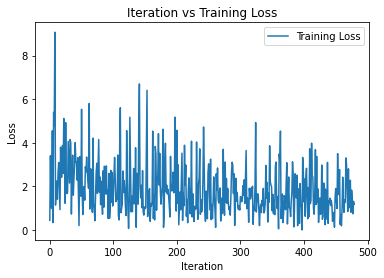

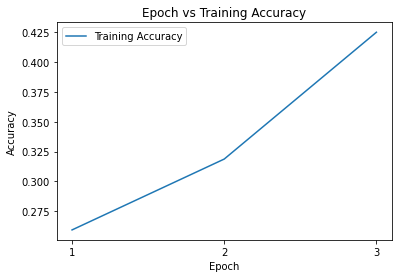

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Plot Iteration vs Training Loss
plt.plot(train_loss, label="Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Iteration vs Training Loss")  
plt.legend()
plt.show()

# Plot Epoch vs Training Accuracy
acc_X = np.arange(len(train_accuracies))+1                          
plt.plot(acc_X, train_accuracies,"-", label="Training Accuracy")
plt.xticks(acc_X)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Epoch vs Training Accuracy")  
plt.legend()
plt.show()


In [35]:
# Testing
from torch.utils.data import DataLoader

# Get test data by DataLoader
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Start testing
model.eval()

with torch.no_grad():
    
    correct = 0
    count = 0
    record = {"labels":list(), "predictions":list()}
    
    pbar = tqdm(test_loader)
    for batch in pbar:
        input_ids = batch['input_values'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs['loss']
        
        # make predictions
        predictions = predict(outputs)

        # count accuracy
        correct += predictions.eq(labels).sum().item()
        count += len(labels)
        accuracy = correct * 1.0 / count

        # show progress along with metrics
        pbar.set_postfix({
            'loss': '{:.3f}'.format(loss.item()),
            'accuracy': '{:.3f}'.format(accuracy)
        })
    
        # record the results
        record["labels"] += labels.cpu().numpy().tolist()
        record["predictions"] += predictions.cpu().numpy().tolist()
        
    pbar.close()
    
time.sleep(0.3)
print("The final accuracy on the test dataset: %s%%" % round(accuracy*100,4))

100%|██████████| 80/80 [00:53<00:00,  1.50it/s, loss=0.504, accuracy=0.350]


The final accuracy on the test dataset: 35.0%


In [56]:
test_df2['emotion']= test_df2.path.apply(lambda x : x.split('/')[2])

In [57]:
# Convert test record to a pandas DataFrame object
from pandas.core.frame import DataFrame
df_record = DataFrame(record)
df_record.columns = ["Ground Truth","Model Prediction"]

def get_emotion(label_id):
    return model.config.id2label[label_id]
    
df_record["Ground Truth"] = df_record.apply(lambda x: get_emotion(x["Ground Truth"]), axis=1)
df_record["Model Prediction"] = df_record.apply(lambda x: get_emotion(x["Model Prediction"]), axis=1)

# Concat test texts and test records
df = pd.concat([test_df2.reset_index(), df_record["Model Prediction"]], axis=1)
df["emotion"] = df.apply(lambda x: x["emotion"][:3], axis=1)

# Show test result
# pd.set_option('display.max_rows', None)    # Display all rows
# df

# Show incorrect predictions 
df[df["emotion"]!=df["Model Prediction"]]


,label,level_1,path,labels,emotions,emotion,Model Prediction
0,0,9762,Emotions/input/Angry/03-01-05-02-02-02-21.wav,0,Angry,Ang,neu
1,0,9459,Emotions/input/Angry/03-02-05-02-01-02-03.wav,0,Angry,Ang,neu
2,0,8388,Emotions/input/Angry/1036_IEO_ANG_HI.wav,0,Angry,Ang,neu
3,0,8280,Emotions/input/Angry/n02.wav,0,Angry,Ang,neu
4,0,8588,Emotions/input/Angry/n04.wav,0,Angry,Ang,neu
...,...,...,...,...,...,...,...
75,3,1089,Emotions/input/Happy/YAF_half_happy.wav,3,Happy,Hap,sad
76,3,1756,Emotions/input/Happy/OAF_tell_happy.wav,3,Happy,Hap,sad
77,3,6,Emotions/input/Happy/1039_TSI_HAP_XX.wav,3,Happy,Hap,neu
78,3,1847,Emotions/input/Happy/1085_IEO_HAP_LO.wav,3,Happy,Hap,neu


In [59]:
df['Model Prediction'].value_counts()

neu    40
sad    31
hap     5
ang     4
Name: Model Prediction, dtype: int64

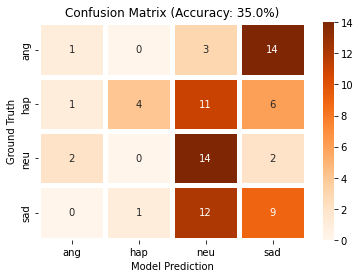

In [58]:
# Display the Confusion Matrix
import seaborn as sns
crosstab = pd.crosstab(df_record["Ground Truth"],df_record["Model Prediction"])
sns.heatmap(crosstab, cmap='Oranges', annot=True, fmt='g', linewidths=5)
accuracy = df_record["Ground Truth"].eq(df_record["Model Prediction"]).sum() / len(df_record["Ground Truth"])
plt.title("Confusion Matrix (Accuracy: %s%%)" % round(accuracy*100,2))
plt.show()